## State-of-the-Art Sentiment Classification in TensorFlow

In the previous tutorial ([1-Construct-TensorFlow-Data-Pipeline.ipynb](https://github.com/ralphbrooks/tensorflow-tutorials/blob/master/1-Construct-TensorFlow-Data-Pipeline.ipynb)), I showed how you can create a data pipeline for a TensorFlow model. Once you have this data pipeline prepared, you are now ready to ingest this data and create a state-of-the-art classifier of emotion in language (a sentiment classifier). 

To this this we are going to make use of the following technologies:

1) <b>Transfer Learning:</b> In 2019, Transfer Learning showed that it could achieve good performance on relatively low amounts of data. The concept is that a model is trained on a large amount of data beforehand, and this "pre-trained" model is then used in a second stage for classification. 

2) [<b>Google BERT:</b>](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) This is model that was pretrained by Google off of information from Wikipedia. It attempts to predict a word in a sentence given the words that PRECEDE the missing word and the words that FOLLOW the missing word. The model combines this prediction task with a [Transformer model architecture](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) which builds a neural network that looks at the emphasis of each word in relation to all other words in the sentence (a concept called self-attention).

3) [<b>Huggingface Transformers:</b>](https://github.com/huggingface/transformers) - A startup company called Huggingface related in 2019 "wrapper code" that simplies using BERT as part of a data pipeline. 




### Step 1: Import and Setup

We will get started by importing in the GPU version of Tensorflow and the Transformers library from Huggingface.

Notes:

* This exercise is going to require running this code with a GPU. I ran this code in AWS Sagemaker using a ml.p3.2xlarge GPU. Keep in mind that this GPU (as of Nov. 2019) costs a little
over $4 / hour to operate.

* Said differently, make sure that you stop or terminate your AWS notebook after completing this example so that you do not incur unnecessary cloud compute fees.



In [1]:
%load_ext autoreload
% autoreload 2

In [2]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.3.1)


Since this exercise involves training a model, it is important that you use the GPU version of tensorflow for the training.

In [3]:
!yes | pip uninstall tensorflow
! pip install tensorflow-gpu==2.0.0

yes: standard output: Broken pipe
yes: write error


In [4]:
!pip install -q transformers==2.1.1

In [5]:
import tensorflow as tf
from transformers import *
from transformers import BertTokenizer, TFBertForSequenceClassification, glue_convert_examples_to_features


In [6]:
tf.__version__

'2.0.0'

### Step 2: Create tf.data.Dataset from TFRecord

In the previous tutorial, we had put together the encoded data as TFRecords. Now, we will set up a transformation pipeline with a ```tf.data.Dataset``` .

A ```tf.data.Dataset``` allows you to construct the pipeline without having to ingest and process all of the data in each step before examining the next transformation step. This is massively critical if you are testing out your pipeline. 

Said differently, the last thing in the world that you want to do is to wait 3-4 minutes during an iteration of code because you are waiting for a stage of preprocessing to complete. 

&nbsp;  
    
The following code extracts the data that will be used to train the model (the tr_ds or train dataset), the data that will be used to validate the accuracy of the model (val_ds) and the holdout set of data that is used for the final verification of model accuracy.

In [7]:
tr_ds = tf.data.TFRecordDataset("data/yelp_train.tfrecord")
val_ds = tf.data.TFRecordDataset("data/yelp_validate.tfrecord")
test_ds = tf.data.TFRecordDataset("data/yelp_test.tfrecord")

The following code will now extract tensors (the basic building blocks in TensorFlow) from the TFRecord. In essence, these tensors have the potential to be used as inputs into the model. 

Notes: 

* When you are extracting features from the TFRecord Dataset, it is important to note that <b>the keys in the feature spec must match the keys that that were used in the TFRecord encoding process </b> (the process that was covered in the previous tutorial). Also note that you don't have to use all of the tensors that are encoded within TFRecord (you could use just a subset of the Tensors). 

In [8]:
# convert the encoded string tensor into the separate tensors that will feed into the model

feature_spec = {
    'idx': tf.io.FixedLenFeature([], tf.int64),
    'sentence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

def parse_example(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_spec)

tr_parse_ds = tr_ds.map(parse_example)
val_parse_ds = val_ds.map(parse_example)
test_parse_ds = test_ds.map(parse_example)

One approach to cleaning up a pipeline is to map a function to the dataset. In this way, the function gets applied to each example. The following code uses this approach to clean up the sentence tensor.

In [9]:

def clean_yelp_string(features):
    revised_sentence = tf.strings.regex_replace(features['sentence'], "\.\.\.", "", replace_global=True)
    revised_sentence = tf.strings.regex_replace(revised_sentence, "\\'", "'", replace_global=True)
    revised_sentence = tf.strings.regex_replace(revised_sentence, "\\n", "", replace_global=True)
    features['sentence'] = revised_sentence
    return features

In [10]:
tr_clean_ds = tr_parse_ds.map(lambda features: clean_yelp_string(features))
val_clean_ds = val_parse_ds.map(lambda features: clean_yelp_string(features))
test_clean_ds = test_parse_ds.map(lambda features: clean_yelp_string(features))

### Step 3: Train the model

Recent research( [https://arxiv.org/abs/1804.07612](https://arxiv.org/abs/1804.07612)) suggests that smaller batch training improves generalization. Based on this, I set the batch size for training at 32. 

In [11]:
BATCH_SIZE = 32

EVAL_BATCH_SIZE = BATCH_SIZE * 2

# XLA is the optimizing compiler for machine learning
# It can potentially increase speed by 15% with no source code changes
USE_XLA = False

# mixed precision results on https://github.com/huggingface/transformers/tree/master/examples
# Mixed precision can help to speed up training time
USE_AMP = False

Now you need to pull in the lengths of the different datasets from the JSON file that we created in the last tutorial. 

In [12]:
# Steps is determined by the number of examples
import json

with open('data/yelp_info.json') as json_file:
    data_info = json.load(json_file)
    
train_examples = data_info['train_length']
valid_examples = data_info['validation_length']
test_examples = data_info['test_length']

train_examples, valid_examples, test_examples

(738, 82, 82)

In [13]:
tf.config.optimizer.set_jit(USE_XLA)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": USE_AMP})

Now that we have a pipeline setup, we need to start the process of converting words into numbers so that they can be processed by the BERT transfer learning backbone. This process is commonly called Tokenization, and Huggingface includes a tokenizer that helps with this process.

The tokenizers are based on the underlying research code. For example, the following are different BERT models that can be utilized within the BERT framework:

    * ``bert-base-uncased``: 12-layer, 768-hidden, 12-heads, 110M parameters
    * ``bert-large-uncased``: 24-layer, 1024-hidden, 16-heads, 340M parameters
    * ``bert-base-cased``: 12-layer, 768-hidden, 12-heads , 110M parameters
    * ``bert-large-cased``: 24-layer, 1024-hidden, 16-heads, 340M parameters
    
As seen above, the different numbers have different levels of complexity and are associated either with uncapitalized text (uncased) or text that has capitalization. I selected the bert-base-cased underlying model because the Yelp utterances have capitalization. I also selected it because in general models that are less complex tend to run faster than models which are more complex.


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

The Transformers framework can use a configuration dictionary in order to set up the hyperparameters for the model. In this case, I explictly use the config to make sure that the model
is looking at num_labels=2. If we had been going through an example with three categories ('Positive', 'Negative', and 'Neutral') as opposed to just two cases ('Positive' and 'Negative') then we would have wanted to use num_labels=3 instead.

In [15]:
# Make use of the following config parameters which are stored in bert_config.json.

# {
#   "attention_probs_dropout_prob": 0.1,
#   "hidden_act": "gelu",
#   "hidden_dropout_prob": 0.1,
#   "hidden_size": 768,
#   "initializer_range": 0.02,
#   "intermediate_size": 3072,
#   "layer_norm_eps": 1e-12,
#   "max_position_embeddings": 512,
#   "num_attention_heads": 12,
#   "num_hidden_layers": 12,
#   "num_labels": 2,
#   "output_attentions": false,
#   "output_hidden_states": false,
#   "output_past": true,
#   "pruned_heads": {},
#   "torchscript": false,
#   "type_vocab_size": 2,
#   "use_bfloat16": false,
#   "vocab_size": 28996
# }

In [16]:
from transformers.configuration_bert import BertConfig
config = BertConfig("bert_config.json")

TensorFlow uses layers of abstraction when putting together a model. Operations (such as matrix algebra) can occur at a low level, and an abstraction of a neural network layer can occur at a higher level. One of these higher levels of abstraction is called a Keras model, and Huggingface uses this model as a way to abstract some of the granular details involved in using BERT for transfer learning.

The following is the syntax to instantiate a keras model with the Huggingface framework. 

In [17]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', config=config)


Now that we have a tokenizer and the model with the right configurations, we need to take our parsed tensors (the tr_parse_ds or train parsed dataset) and feed them into the Huggingface framework. To do this, we are going to make a slight modification to the glue_convert_examples_to_features code found in the
HuggingFace transformers repo. Here we are going to use the sst-2 task (the Stanford Sentiment Treebank binary classification task) because this task also works with binary classification. Because our example uses '1' for 'Negative' and '3' for Positive, we need to make this explicit by including the label_list keyword when doing the conversion. 


Notes:
* Huggingface uses the similar strategy of taking the TFExamples and using a dataset in order to convert the "sentence" and "labels" into inputs that are needed by BERT (inputs such as 'input_ids', 'attention_mask', and 'token_type_ids'). As disscussed earlier in the workbook, this transformation process makes it quick to test out the conversion on a couple of data points and to move onto the next step without waiting for the full conversion to complete. 

In [18]:
train_dataset = glue_convert_examples_to_features(examples=tr_clean_ds, tokenizer=tokenizer
                                                  , max_length=128, task='sst-2'
                                                  , label_list =['1', '3'])

Repeate the same transformation that you did for the training set on the information that will be used to validate the performance of the model. 

In [19]:
valid_dataset = glue_convert_examples_to_features(examples=val_clean_ds, tokenizer=tokenizer
                                                  , max_length=128, task='sst-2'
                                                  , label_list =['1', '3'])

One of the advantage of using the dataset approach is that you can specify the size of your batches, and you can shuffle the data.

In [20]:
train_dataset = train_dataset.shuffle(train_examples).batch(BATCH_SIZE).repeat(-1)

valid_dataset = valid_dataset.batch(EVAL_BATCH_SIZE)

In this next section, we need to configure the loss function, the optimizer, and any additional metrics that we want to capture.

<b>Loss:</b> 

This is the objective that the model is trying to minimize. In our example, the HuggingFace framework converts our Negatives ('1') and our Positives ('3') into '0' and '1' and compares this against the distribution of predicted classes. Said differently, we are trying to compare how similar the actual distribution is to the predicted distribution, and this is captured in the loss function called ```SparseCategoricalCrossentropy``` . 

A good discussion on cross entropy can be found at [The Gradient](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/)

<b>Optimizer:</b>

Deep learning is the process of minimizing a loss function. The process that determines what steps to try out in each iteration is commonly referred to as the optimizer. For this exercise, I used the [Adam optimization algorithm](https://arxiv.org/pdf/1412.6980.pdf) which tends to work well in a variety of situations. 

<b> Metric: </b> 

As a basic metric, we should look at the number of times that the actual class is identical  to what is predicted. 

Unfortunately ,the model currently generates unscaled outputs for each example (an unscaled output for the negative class and another unscaled output for the positive class). Said differently, the model generates outputs before they are converted into probabilities (the conversion happens with a softmax function). Because of all of this, the appropriate metric to use would be ```SparseCategoricalAccuracy```.

&nbsp;  

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

if USE_AMP:
    # loss scaling is currently required when using mixed precision
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, 'dynamic')

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=opt, loss=loss, metrics=[metric])

The TensorFlow documentation states the following:

<b>If x is a tf.data dataset, and 'steps_per_epoch' is None, the epoch will run until the input dataset is exhausted.</b>

Because these datasets can be a precursor to training on TFRecords of significant size, it is best practice to specificially state the number of steps that will be processed per epoch in the train and validation stage. 



In [22]:
train_steps = train_examples//BATCH_SIZE
valid_steps = valid_examples//EVAL_BATCH_SIZE

GPUs run up to 27x faster that CPUs for model training. Because of this, it is critical that the following preconditions are in place:

* You are using the version of Tensflow for GPUs
* The code has access to a GPU

To confirm the preconditions, I run the following code to detect GPUs and to see the physical devices that are available.

In [23]:
# GPU USAGE
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=train_steps,
                    validation_data=valid_dataset, validation_steps=valid_steps)

Train for 23 steps, validate for 1 steps
23/23 [==============================] - 35s 2s/step - loss: 0.3049 - accuracy: 0.8899 - val_loss: 0.2429 - val_accuracy: 0.9062



The above output shows the following 

* In the first epoch, the train accuracy is 88% and the validation accuracy is 90%.

At this point, you see that the model has accuracy of 90%. This is fairly good considering that the Yelp rating captures the full sentiment of the user, but that in many cases, the Yelp API is only giving you part of the actual text review.

Notes:
1) In different runs of this notebook, the validation accuracy typically hits 90% with either 1 or 2 epochs. 

### Step 4: Evaluate the results of the model

The results above seem to look good. At this point, it is worth doing one final check before calling it a day.

In [31]:
test_dataset = glue_convert_examples_to_features(examples=test_clean_ds, tokenizer=tokenizer
                                                  , max_length=128, task='sst-2'
                                                  , label_list =['1', '3'])

In [32]:
test_dataset = test_dataset.batch(EVAL_BATCH_SIZE)

In [33]:
model.evaluate(test_dataset)

2/2 [==============================] - 1s 683ms/step - loss: 0.3934 - accuracy: 0.8537


[0.39343981444835663, 0.85365856]

Here we see that the model has 85% accuracy in the test set. 

### Step 5: Create a Confusion Matrix

&nbsp;  

We can also visualize the evaluation in terms of how many true positives, true negatives, false positives, and false negatives occur. This visualization is commonly called a Confusion Matrix.

Creation of the confusion matrix involves the following steps:

1) Take the unnormalized outputs from the model (the logits) and compress them into probabilities (that by definition are between 0 and 1). The function that converts logits into probabilities is the softmax function.

2) Once you have probabilities for each prediction, identify predicted emotion ('Negative' or 'Positive') by selecting the probability with the largest value. This is accomplished with the argmax function.


In [34]:
y_pred = tf.nn.softmax(model.predict(test_dataset))

In [35]:
y_pred[:10]

<tf.Tensor: id=46729, shape=(10, 2), dtype=float32, numpy=
array([[0.90327775, 0.09672225],
       [0.91567016, 0.0843299 ],
       [0.03727874, 0.9627212 ],
       [0.06855108, 0.931449  ],
       [0.89795446, 0.10204558],
       [0.9118943 , 0.08810564],
       [0.91609144, 0.08390854],
       [0.57343847, 0.42656156],
       [0.02170555, 0.9782945 ],
       [0.2815531 , 0.71844685]], dtype=float32)>

In [36]:
y_pred_argmax = tf.math.argmax(y_pred, axis=1)

In [37]:
y_pred_argmax[:10]

<tf.Tensor: id=46735, shape=(10,), dtype=int64, numpy=array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1])>

3) Use a simple for loop in order to pull the true values from the test dataset. 

Be aware though that the Huggingface framework converted the labels that we had ('1' for negative and '3' for positive) into '0' for negative and '1' for positive.

In [38]:
y_true = tf.Variable([], dtype=tf.int64)

for features, label in test_dataset.take(-1):
    y_true = tf.concat([y_true, label], 0)

In [39]:
y_true[:30]

<tf.Tensor: id=46766, shape=(30,), dtype=int64, numpy=
array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0])>

4)  Use tf.math.confusion.matrix in order to determine true positives, true negatives, false positives, and false negatives from the true labels (y_true) and the predictions (y_pred_argmax). 

5) Use seaborn and matplotlib to visualize the confusion matrix. 

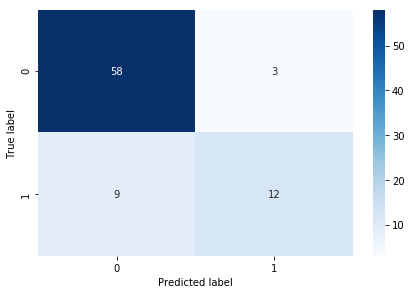

In [40]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def visualize_confusion_matrix(y_pred_argmax, y_true):
    """

    :param y_pred_arg: This is an array with values that are 0 or 1
    :param y_true: This is an array with values that are 0 or 1
    :return:
    """

    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


visualize_confusion_matrix(y_pred_argmax, y_true)

Analysis of the above shows the following:

* The analysis of the above shows that if the customer is expressing negative sentiment. Then the classifier gets it right 95% of the time. 
* If the model is asked to evaluate positive sentiment, then the model gets it right 57% of the time.


### Step 6: Create the Saved Model

In [ ]:
Once you have a model with decent accuracy, 

In [43]:
tf.saved_model.save(model, '/20191227')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


PermissionDeniedError: /20191227; Permission denied

&nbsp;

Congratulations. You made it to the end of the tutorial and now you have a process that takes you from building a data pipeline to having an accurate model.

Also, for the first time in 10 years, I am back on the job market looking for consulting opportunities or full time employment.  If you think I can be of help to you, feel free to reach out. I am on twitter at [@ralphbrooks](https://twitter.com/ralphbrooks) .